In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import colorcet as cc
from matplotlib.colors import ListedColormap

import datetime
import glob
import re

/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


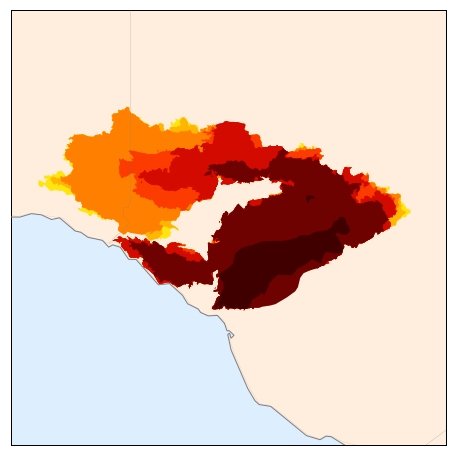

In [2]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
m = Basemap(projection='lcc', resolution='h',
           width=0.7e5, height=0.7e5,
           lat_0=34.4, lon_0=-119.27)

m.drawmapboundary(fill_color='#DDEEFF');
m.fillcontinents(color='#FFEEDD');
m.drawcoastlines(color='gray', zorder=3);
m.drawcounties(color='gray', zorder=3);

def draw_shapefile(filename,color):
    filename = filename.rstrip('.shp')
    m.readshapefile(filename, 'temp', drawbounds=False)
    patches = []

    for info, shape in zip(m.temp_info, m.temp):
        patches.append(Polygon(np.array(shape), True))
    ax.add_collection(PatchCollection(patches,
                                      facecolor=color,
                                      edgecolor='none',
                                      linewidths=1,
                                      zorder=2))

files = glob.glob('perimeters/*.shp')
files.sort()

def get_day(fname):
    match = re.search('201712([0-9]+)', fname)
    return int(match.group(1))

days = np.array(map(get_day, files)).astype(float)

cmap = cc.m_fire

shade = (days - np.min(days)) / (np.max(days) - np.min(days))
shade = 0.8*shade + 0.1

perimeters = zip(days, files, map(cmap, shade))

for day, fname, color in sorted(perimeters, reverse=True):
    draw_shapefile(fname, color)


In [3]:
lons = np.linspace(m.boundarylonmin, m.boundarylonmax, 200)
lats = np.linspace(np.min(m.boundarylats), np.max(m.boundarylats), 200)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-119.652916634,34.0846490988,-118.887083366,34.7147611255&bboxSR=4269&imageSR=4269&size=1500,1234&dpi=96&format=png32&f=image


/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


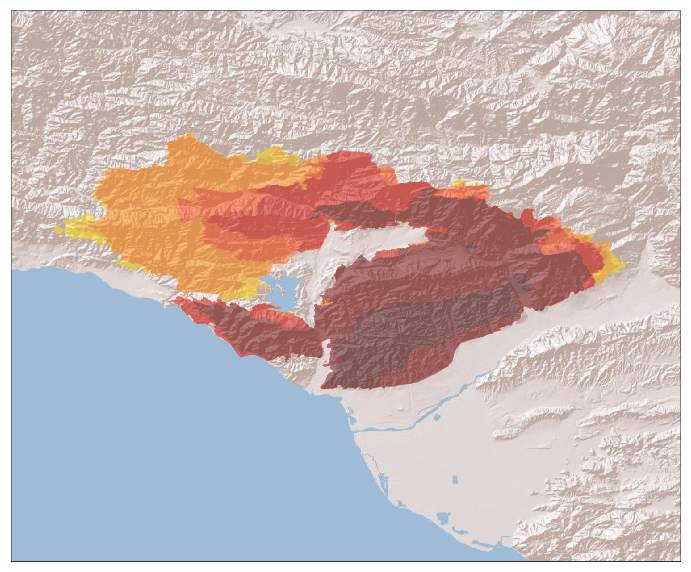

In [4]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

m = Basemap(llcrnrlat=lats.min(), urcrnrlat=lats.max(),
            llcrnrlon=lons.min(), urcrnrlon=lons.max(),
            epsg=4269, resolution='h')

# m.drawmapboundary(fill_color='#DDEEFF');
# m.fillcontinents(color='#FFEEDD', zorder=1);
# m.drawcoastlines(color='gray', zorder=3);
# m.drawcounties(color='gray', zorder=3);

m.arcgisimage(service='World_Shaded_Relief',
              xpixels=1500, verbose=True,
              ax=ax);

def draw_shapefile(filename,color,zorder=2):
    filename = filename.rstrip('.shp')
    m.readshapefile(filename, 'temp', drawbounds=False)
    patches = []

    for info, shape in zip(m.temp_info, m.temp):
        patches.append(Polygon(np.array(shape), True))
        
    ax.add_collection(PatchCollection(patches,
                                      facecolor=color,
                                      edgecolor='none',
                                      linewidths=1,
                                      zorder=zorder))
    
for day, fname, color in sorted(perimeters, reverse=True):
    draw_shapefile(fname, color, zorder=2)
    
# this is a total hack, but i download the arcgis image manually, then show it
# on top of the existing plot.  i could not seem to get arcgisimage() to obey
# alpha or zorder arguments...
#
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.imshow(plt.imread('perimeter-map.png'), alpha=0.5, zorder=3)
newax.get_xaxis().set_visible(False)
newax.get_yaxis().set_visible(False)

In [5]:
fig.savefig('thomas-perimeter.png', dpi=200, bbox_inches='tight')